In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
project_path = '/content/drive/MyDrive/BLG454EProject'
os.chdir(project_path)

!ls

cifar10_train_eval.ipynb  fashion_train_eval.ipynb
distiller		  mnist_train_eval.ipynb


This notebook compares how well a simple **ConvNet** model performs when trained on:
1. The **full** CIFAR10 training set (60 k images)
2. A **randomly‑sampled** subset containing **10 images per class** (100 images total)
3. A **distilled** synthetic set generated with Gradient Matching

We evaluate each model on the **canonical CIFAR10 test split (10 k images)** and summarise the results.


In [7]:
import os, random, math, time, copy
import numpy as np
from pathlib import Path
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, TensorDataset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from distiller.models.ConvNet import ConvNet

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)


Using device: cuda


In [8]:
def train(model, loader, criterion, optimizer, epochs=5, log_interval=100):
    model.train()
    for epoch in range(1, epochs + 1):
        running_loss = 0.0
        for batch_idx, (inputs, targets) in enumerate(loader, 1):
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if batch_idx % log_interval == 0 or batch_idx == len(loader):
                print(f'Epoch {epoch}/{epochs} | Batch {batch_idx}/{len(loader)} | Loss: {running_loss / batch_idx:.4f}', end='\r')
        print(f'Epoch {epoch} finished. Avg Loss: {running_loss / len(loader):.4f}')

def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            preds = outputs.argmax(dim=1)
            correct += (preds == targets).sum().item()
            total += targets.size(0)
    return 100.0 * correct / total


In [9]:

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
])

root = Path('distiller/data')
full_train = datasets.CIFAR10(root, train=True, download=True, transform=transform)
test_set = datasets.CIFAR10(root, train=False, download=True, transform=transform)

test_loader = DataLoader(test_set, batch_size=512, shuffle=False, num_workers=2, pin_memory=True)

print(f'Full training set size: {len(full_train)}')

Full training set size: 50000


## Training on the **full** MNIST training set

In [10]:
BATCH_SIZE_FULL = 128
EPOCHS_FULL = 5

full_loader = DataLoader(full_train, batch_size=BATCH_SIZE_FULL, shuffle=True, num_workers=2, pin_memory=True)

model_full = ConvNet().to(device)
optimizer = optim.Adam(model_full.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

train(model_full, full_loader, criterion, optimizer, epochs=EPOCHS_FULL, log_interval=200)
acc_full = evaluate(model_full, test_loader)
print(f'\nTest accuracy (full data): {acc_full:.2f}%')

Epoch 1 finished. Avg Loss: 1.2294
Epoch 2 finished. Avg Loss: 0.8354
Epoch 3 finished. Avg Loss: 0.7008
Epoch 4 finished. Avg Loss: 0.6055
Epoch 5 finished. Avg Loss: 0.5356

Test accuracy (full data): 77.17%


## Training on a **random** subset (10 images × 10 classes = 100 images)

In [11]:
def stratified_random_subset(dataset, per_class=10):
    targets = np.array(dataset.targets)
    indices = []
    for cls in range(10):
        cls_idx = np.where(targets == cls)[0]
        indices.extend(np.random.choice(cls_idx, per_class, replace=False))
    return indices

subset_indices = stratified_random_subset(full_train, per_class=10)
small_train = Subset(full_train, subset_indices)
print('Subset size:', len(small_train))

BATCH_SIZE_SMALL = 32
EPOCHS_SMALL = 50  # More epochs because dataset is tiny

small_loader = DataLoader(small_train, batch_size=BATCH_SIZE_SMALL, shuffle=True, num_workers=2, pin_memory=True)

model_small = ConvNet().to(device)
optimizer_small = optim.Adam(model_small.parameters(), lr=1e-3)
criterion_small = nn.CrossEntropyLoss()

train(model_small, small_loader, criterion_small, optimizer_small, epochs=EPOCHS_SMALL, log_interval=1)
acc_small = evaluate(model_small, test_loader)
print(f'\nTest accuracy (random 100 examples): {acc_small:.2f}%')

Subset size: 100
Epoch 1 finished. Avg Loss: 2.5445
Epoch 2 finished. Avg Loss: 1.9066
Epoch 3 finished. Avg Loss: 1.8771
Epoch 4 finished. Avg Loss: 1.4165
Epoch 5 finished. Avg Loss: 1.1948
Epoch 6 finished. Avg Loss: 1.0566
Epoch 7 finished. Avg Loss: 0.9145
Epoch 8 finished. Avg Loss: 0.7722
Epoch 9 finished. Avg Loss: 0.5814
Epoch 10 finished. Avg Loss: 0.6673
Epoch 11 finished. Avg Loss: 0.3963
Epoch 12 finished. Avg Loss: 0.3634
Epoch 13 finished. Avg Loss: 0.2816
Epoch 14 finished. Avg Loss: 0.2552
Epoch 15 finished. Avg Loss: 0.2134
Epoch 16 finished. Avg Loss: 0.1645
Epoch 17 finished. Avg Loss: 0.1347
Epoch 18 finished. Avg Loss: 0.1149
Epoch 19 finished. Avg Loss: 0.0931
Epoch 20 finished. Avg Loss: 0.0759
Epoch 21 finished. Avg Loss: 0.0656
Epoch 22 finished. Avg Loss: 0.0543
Epoch 23 finished. Avg Loss: 0.0452
Epoch 24 finished. Avg Loss: 0.0397
Epoch 25 finished. Avg Loss: 0.0323
Epoch 26 finished. Avg Loss: 0.0345
Epoch 27 finished. Avg Loss: 0.0255
Epoch 28 finished. A

## Training on the **distilled synthetic** set

In [12]:
SYNSET_PATH = 'distiller/syndata/CIFAR10_ConvNet_ipc-10_exp-0.pt'

assert Path(SYNSET_PATH).exists(), (
    f'Distilled file not found at {SYNSET_PATH}. ' \
    'Upload it to the Colab session or place it in the working directory.'
)

checkpoint = torch.load(SYNSET_PATH, map_location='cpu')

# Expected keys: images (n, 1, 28, 28) tensor, labels (n) tensor
synthetic_images = checkpoint.get('syn_imgs') if isinstance(checkpoint, dict) else checkpoint[0]
synthetic_labels = checkpoint.get('syn_labels') if isinstance(checkpoint, dict) else checkpoint[1]

print('Synthetic set shape:', synthetic_images.shape)

distill_ds = TensorDataset(synthetic_images, synthetic_labels)
BATCH_SIZE_DISTILL = 32
EPOCHS_DISTILL = 300

distill_loader = DataLoader(distill_ds, batch_size=BATCH_SIZE_DISTILL, shuffle=True)

model_distill = ConvNet().to(device)
optimizer_distill = optim.Adam(model_distill.parameters(), lr=1e-3)
criterion_distill = nn.CrossEntropyLoss()

train(model_distill, distill_loader, criterion_distill, optimizer_distill, epochs=EPOCHS_DISTILL, log_interval=1)
acc_distill = evaluate(model_distill, test_loader)
print(f'\nTest accuracy (distilled set): {acc_distill:.2f}%')

Synthetic set shape: torch.Size([100, 3, 32, 32])
Epoch 1 finished. Avg Loss: 2.4079
Epoch 2 finished. Avg Loss: 1.7916
Epoch 3 finished. Avg Loss: 1.6061
Epoch 4 finished. Avg Loss: 1.2879
Epoch 5 finished. Avg Loss: 0.9289
Epoch 6 finished. Avg Loss: 0.7724
Epoch 7 finished. Avg Loss: 0.6281
Epoch 8 finished. Avg Loss: 0.5099
Epoch 9 finished. Avg Loss: 0.4686
Epoch 10 finished. Avg Loss: 0.3258
Epoch 11 finished. Avg Loss: 0.2721
Epoch 12 finished. Avg Loss: 0.2141
Epoch 13 finished. Avg Loss: 0.1604
Epoch 14 finished. Avg Loss: 0.1278
Epoch 15 finished. Avg Loss: 0.1019
Epoch 16 finished. Avg Loss: 0.0743
Epoch 17 finished. Avg Loss: 0.0738
Epoch 18 finished. Avg Loss: 0.0569
Epoch 19 finished. Avg Loss: 0.0425
Epoch 20 finished. Avg Loss: 0.0409
Epoch 21 finished. Avg Loss: 0.0443
Epoch 22 finished. Avg Loss: 0.0345
Epoch 23 finished. Avg Loss: 0.0323
Epoch 24 finished. Avg Loss: 0.0262
Epoch 25 finished. Avg Loss: 0.0220
Epoch 26 finished. Avg Loss: 0.0282
Epoch 27 finished. Avg 

## Result Summary

Full Data   : 77.17%
Random 100  : 26.69%
Distilled Set: 33.91%


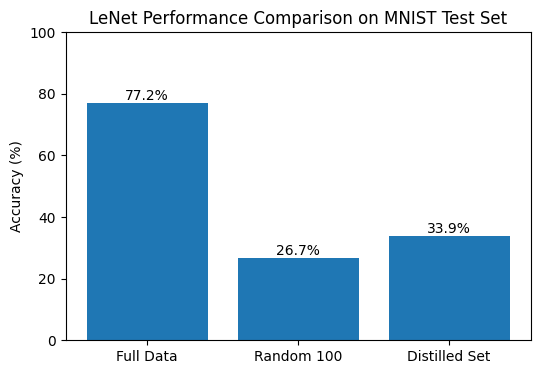

In [13]:
results = {
    'Full Data': acc_full,
    'Random 100': acc_small,
    'Distilled Set': acc_distill,
}

for k, v in results.items():
    print(f'{k:<12}: {v:5.2f}%')

# Bar chart
plt.figure(figsize=(6,4))
plt.bar(results.keys(), results.values())
plt.ylabel('Accuracy (%)')
plt.title('LeNet Performance Comparison on MNIST Test Set')
plt.ylim(0, 100)
for i, v in enumerate(results.values()):
    plt.text(i, v + 1, f'{v:.1f}%', ha='center')
plt.show()
